<a href="https://colab.research.google.com/github/jaideep6214/Project-1-Music-Generator-using-LSTM/blob/main/Music_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Importing Libraries**

In [2]:
import pandas as pd
import numpy as np
import music21
from music21 import *
import json
from IPython.display import Image, Audio
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
from collections import Counter
np.random.seed(42)
import tensorflow 


## **Importing MIDI Files (Music Files)**

In [3]:
all_midis= []
for i in range (1,17):
  file = str(i)
  if (len(file)==1):      #Making the number in 000 format
    file = "00"+file
  elif (len(file)==2):
    file = "0"+file
  print(file)
  midfilepath = "/content/gdrive/My Drive/Projects/Music Generation/liszt/"+file+".mid/"   #midi file path
  midi = converter.parse(midfilepath)  #parse MIDI, MusicXML, and ABC
  all_midis.append(midi)

001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016


In [4]:
len(all_midis)

16

In [11]:
all_midis[0]

<music21.stream.Score 0x7faf7f0286d0>

## **Extract Notes**

In [12]:
#PartitionByInstrument function, we are able break up the file into individual instruments, if there are multiple instruments.
#A note is a single letter. It's the smallest part of musical language. A chord is like a word: it's made up of multiple notes
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)   #All notes in our dataset
print("Total notes in all the Liszt midis in the dataset:", len(Corpus))

Total notes in all the Liszt midis in the dataset: 55474


In [13]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['9.2', '9.2', '2.5', '4.9', '9', 'C#4', '1.7', '9', '9.2', '2.5.9', '9.0.4', '9.0.4', '9', '0.6', '9.0.3', '0.6', '0.3', 'A2', 'G#2', 'A2', 'G#2', 'A2', 'G#2', 'A2', 'G#2', '6.9.0', '0.3', 'A2', 'G#2', 'A2', 'G#2', 'A2', 'G#2', 'A2', 'G#2', 'A2', 'G#2', 'A2', '0.6', '9', '0.3', 'G#2', 'A2', 'G#2', 'A2', 'G#2', 'A2', 'G#2', 'A2', 'G2']


In [64]:
with open("Corpus3.txt", "w") as f:  #Saving the Corpus
    for s in Corpus:
        f.write(str(s) +"\n")
!cp Corpus3.txt "/content/gdrive/My Drive/Projects/Music Generation/"

In [7]:
Corpus = []
with open("/content/gdrive/My Drive/Projects/Music Generation/Corpus2.txt", "r") as f:
  for line in f:
    Corpus.append((line.strip()))

In [14]:
len(Corpus)

55474

## **Data Exploration**

In [25]:
count_num = Counter(Corpus) # item : occurance
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 366


In [27]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 151.56830601092895
Most frequent note in Corpus appeared: 899 times
Least frequent note in Corpus appeared: 1 time


In [28]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 236


In [29]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 52334


In [34]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))
L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 52334
Number of unique characters: 267


In [59]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

#Another Approach
# length = 20
# features = []
# targets = []
# for i in range(length, L_corpus - length, 1):
#     feature = Corpus[i-length:i + length]
#     target = Corpus[i]
#     features.append([mapping[j] for j in feature])
#     targets.append(mapping[target])

# L_datapoints = len(targets)
# print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 52294


In [60]:
print(features[0])
print(targets[0])
print(features[1])
print(targets[1])
print(features[2])
print(targets[2])
print(features[3])
print(targets[3])
print(features[4])
print(targets[4])
print(features[5])
print(targets[5])

[191, 191, 74, 116, 175, 212, 175, 191, 181, 181, 175, 19, 19, 7, 193, 254, 193, 254, 193, 254, 193, 254, 7, 193, 254, 193, 254, 193, 254, 193, 254, 193, 254, 193, 19, 175, 7, 254, 193, 254]
193
[191, 74, 116, 175, 212, 175, 191, 181, 181, 175, 19, 19, 7, 193, 254, 193, 254, 193, 254, 193, 254, 7, 193, 254, 193, 254, 193, 254, 193, 254, 193, 254, 193, 19, 175, 7, 254, 193, 254, 193]
254
[74, 116, 175, 212, 175, 191, 181, 181, 175, 19, 19, 7, 193, 254, 193, 254, 193, 254, 193, 254, 7, 193, 254, 193, 254, 193, 254, 193, 254, 193, 254, 193, 19, 175, 7, 254, 193, 254, 193, 254]
193
[116, 175, 212, 175, 191, 181, 181, 175, 19, 19, 7, 193, 254, 193, 254, 193, 254, 193, 254, 7, 193, 254, 193, 254, 193, 254, 193, 254, 193, 254, 193, 19, 175, 7, 254, 193, 254, 193, 254, 193]
254
[175, 212, 175, 191, 181, 181, 175, 19, 19, 7, 193, 254, 193, 254, 193, 254, 193, 254, 7, 193, 254, 193, 254, 193, 254, 193, 254, 193, 254, 193, 19, 175, 7, 254, 193, 254, 193, 254, 193, 254]
193
[212, 175, 191, 181, 18

In [53]:
len(features[1])

40

In [54]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints,2* length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

In [55]:
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
'''
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)
'''

from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), recurrent_dropout=0.3, return_sequences=True))
model.add(LSTM(512))
model.add(BatchNorm())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNorm())
model.add(Dropout(0.3))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="rmsprop")


In [57]:
#Model's Summary               
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 512)           1052672   
                                                                 
 lstm_1 (LSTM)               (None, 512)               2099200   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

In [ ]:
history = model.fit(X_train, y_train, batch_size=256, epochs=200)

[Text(0.5, 0, 'Epochs')]

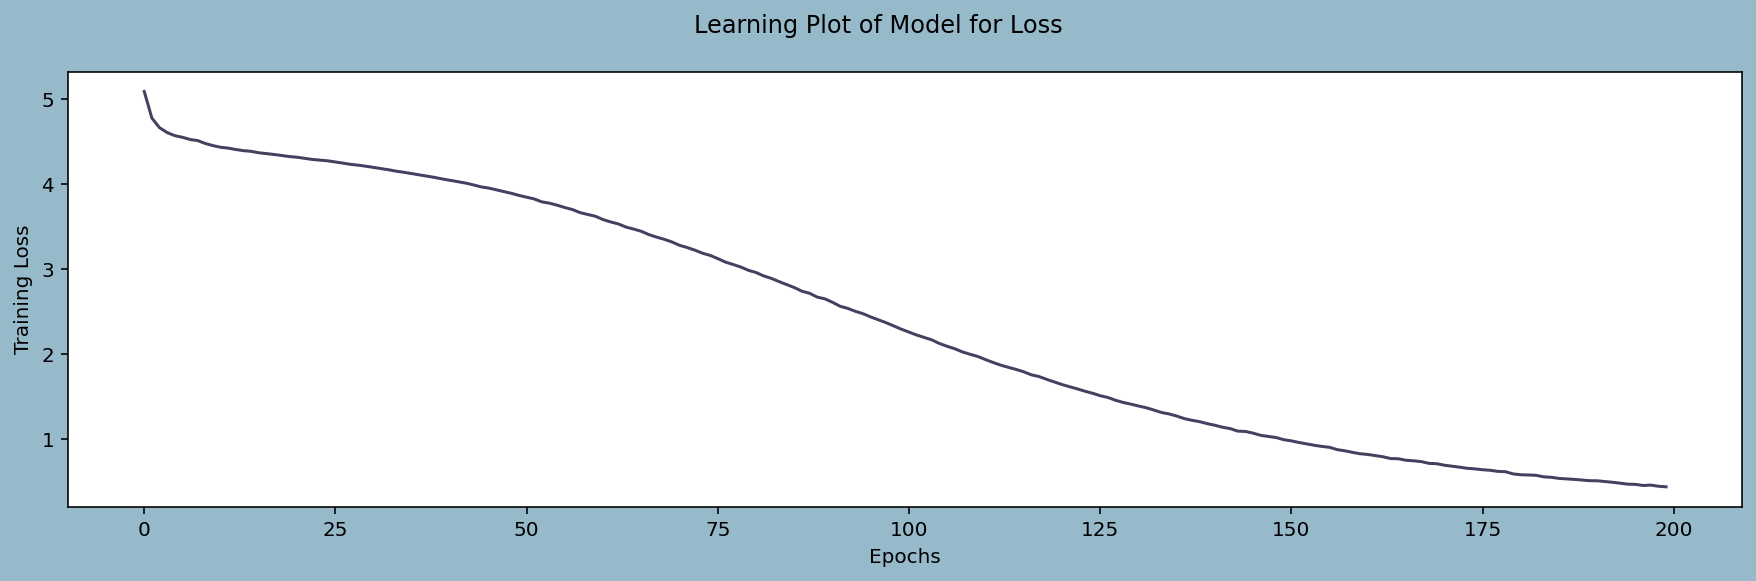

In [82]:
#Plotting the learnings 
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [83]:
from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model.to_json()


with open("model3.json", "w") as json_file:
    json_file.write(model_json)
!cp model3.json "/content/gdrive/My Drive/Projects/Music Generation/"

# serialize weights to HDF5
model.save_weights("model3.h5")
!cp model3.h5 "/content/gdrive/My Drive/Projects/Music Generation/"

In [92]:
def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)    #List of Notes 
    return Music,Melody_midi


#getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(600)

In [93]:
Melody.write('midi','music.mid')
!cp music.mid "/content/gdrive/My Drive/Projects/Music Generation/"